In [2]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10, mnist
import matplotlib.pyplot as plt

# Keras functional api

## Сеть в столбик

In [3]:
tf.random.set_seed(1)
# Создаем код для нашей модели
# входящий слой формат картинки 32 на 32 3х канального цвета
input = keras.Input(shape=(32,32,3))
# Conv2D - слой свертки по изображениям
x = layers.Conv2D(32, 3, activation='relu')(input)
x = layers.MaxPool2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D(2, padding='same')(x)
# слой для выравнивания выходных данных
x = layers.Flatten()(x)
# Dense - слой полносвязной сети
x = layers.Dense(256, activation='relu')(x)
# выкидывает какие-то значения на выходе
x = layers.Dropout(0.5)(x)
output = layers.Dense(10, activation='softmax')(x)
# на основе кода сверху генерируем модель с помощью:
model = keras.Model(inputs=input, outputs=output)

Показываем нашу модеь изнутри

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0     

## Dataset

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [8]:
# Нормализуем наш датасет
x_train = x_train /255
x_test = x_test/255
#  приводим к категориальному формату
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
# Добавляем оптимизатор, функцию потерь и метрику качества в нашу модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Обучаем модель
model.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
625/625 [==============================] - 22s 34ms/step - loss: 1.5874 - accuracy: 0.4220 - val_loss: 1.2809 - val_accuracy: 0.5588
Epoch 2/20
625/625 [==============================] - 21s 33ms/step - loss: 1.2501 - accuracy: 0.5557 - val_loss: 1.0974 - val_accuracy: 0.6136
Epoch 3/20
625/625 [==============================] - 21s 34ms/step - loss: 1.1027 - accuracy: 0.6116 - val_loss: 1.0818 - val_accuracy: 0.6196
Epoch 4/20
625/625 [==============================] - 21s 34ms/step - loss: 0.9961 - accuracy: 0.6497 - val_loss: 0.9314 - val_accuracy: 0.6726
Epoch 5/20
625/625 [==============================] - 21s 34ms/step - loss: 0.9245 - accuracy: 0.6749 - val_loss: 0.8939 - val_accuracy: 0.6881
Epoch 6/20
625/625 [==============================] - 20s 32ms/step - loss: 0.8675 - accuracy: 0.6961 - val_loss: 0.9138 - val_accuracy: 0.6864
Epoch 7/20
625/625 [==============================] - 20s 32ms/step - loss: 0.8088 - accuracy: 0.7150 - val_loss: 0.8339 - val_accuracy:

In [10]:
# Вычисляем точность нашей модели
print(model.evaluate(x_test, y_test))

313/313 [==============================] - 2s 6ms/step - loss: 0.9680 - accuracy: 0.7241
[0.9679670929908752, 0.7240999937057495]


## Сеть с помощью класса

In [13]:
# сделали класс сверточного слоя
class TfConv2D(tf.Module):
    def __init__(self, kernel=(3,3), channels=1, strides=(2,2), padding='SAME', activation='relu'):
        super().__init__()
        self.kernel = kernel        # Размер ядра
        self.channels = channels    # Число выходных каналов
        self.strides = strides      # Смещение в плоскости канала
        self.padding = padding      # режим формирования выходных каналов
        self.activate = activation  # функция активации
        self.fl_init=False

    def __call__(self, x):
        if not self.fl_init:
            #  формируем весовые кофициенты под формат
            # [kernel_x, kernel_y, input_channels, output_channels]
            # truncated_normal - нормальные случайные величины, со средне квадратическим отклонением - stddev=0.1
            self.w = tf.random.truncated_normal((*self.kernel, x.shape[-1], self.channels), stddev=0.1, dtype=tf.double)
            self.b = tf.zeros([self.channels], dtype=tf.double)

            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b)

            self.fl_init = True
        y = tf.nn.conv2d(x, self.w, strides=(1, *self.strides, 1), padding=self.padding)+self.b

        if self.activate == 'relu':
            return tf.nn.relu(y)
        elif self.activate == 'softmax':
            return tf.nn.softmax(y)
        
        return y

In [15]:
layer1 = TfConv2D((3, 3), 32)
y = layer1(tf.expand_dims(x_test[0], axis=0))
print(y.shape)
y = tf.nn.max_pool2d(y, ksize=(1,2,2,1), strides=(1,2,2,1), padding="SAME")
print(y.shape)

(1, 16, 16, 32)
(1, 8, 8, 32)


## Модель автоинкодера

In [17]:
enc_input = layers.Input(shape=(28,28,1))
# Conv2D - слой свертки по изображениям
x = layers.Conv2D(32, 3, activation='relu')(enc_input)
x = layers.MaxPool2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D(2, padding='same')(x)
# слой для выравнивания выходных данных
x = layers.Flatten()(x)
enc_output = layers.Dense(8, activation='linear')(x)
encoder = keras.Model(enc_input, enc_output, name="encoder")

In [18]:
dec_input = keras.Input(shape=(8,), name='encoded_img')
x = layers.Dense(7*7*8, activation='relu')(dec_input)
x = keras.layers.Reshape((7, 7, 8))(x)
x = layers.Conv2DTranspose(64, 5, strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 5, strides=(2,2), activation="linear", padding='same')(x)
x = keras.layers.BatchNormalization()(x)
dec_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = keras.Model(dec_input, dec_output, name="decoder")

In [19]:
autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = encoder(autoencoder_input)
autoencoder_output = decoder(x)

autoencoder = keras.Model(autoencoder_input, autoencoder_output, name='autoencoder')

In [21]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Нормализуем наш датасет
x_train = x_train.astype('float32') /255.0
x_test = x_test.astype('float32')/255.0
#  приводим к категориальному формату
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

11490434/11490434 [==============================] - 2s 0us/step


In [22]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
autoencoder.fit(x_train, x_train, batch_size=32, epochs=1)

1875/1875 [==============================] - 82s 43ms/step - loss: 0.0300


In [24]:
h = encoder.predict(tf.expand_dims(x_test[0], axis=0))
img = decoder.predict(h)

1/1 [==============================] - 0s 146ms/step


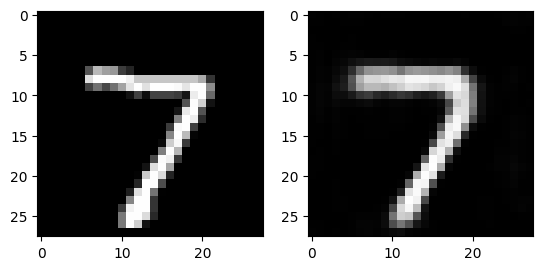

In [25]:
plt.subplot(121)
plt.imshow(x_test[0], cmap='gray')
plt.subplot(122)
plt.imshow(img.squeeze(), cmap='gray')
plt.show()

# ResNet by hands

In [2]:
tf.random.set_seed(1)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train /255
x_test = x_test/255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [5]:
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_2_output = layers.add([x, block_1_output])
x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_3_output = layers.add([x, block_2_output])
x = layers.Conv2D(64, 3, activation='relu')(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='toy_resnet')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
model.fit(x_train, y_train, batch_size=64, epochs=15, validation_split=0.2)

Epoch 1/15
625/625 [==============================] - 62s 96ms/step - loss: 1.8198 - accuracy: 0.2907 - val_loss: 1.5030 - val_accuracy: 0.4366
Epoch 2/15
625/625 [==============================] - 59s 94ms/step - loss: 1.3801 - accuracy: 0.4895 - val_loss: 1.2164 - val_accuracy: 0.5520
Epoch 3/15
625/625 [==============================] - 58s 92ms/step - loss: 1.1343 - accuracy: 0.5881 - val_loss: 1.0367 - val_accuracy: 0.6291
Epoch 4/15
625/625 [==============================] - 58s 93ms/step - loss: 0.9664 - accuracy: 0.6516 - val_loss: 0.9046 - val_accuracy: 0.6817
Epoch 5/15
625/625 [==============================] - 57s 91ms/step - loss: 0.8618 - accuracy: 0.6914 - val_loss: 0.8476 - val_accuracy: 0.6980
Epoch 6/15
625/625 [==============================] - 56s 90ms/step - loss: 0.7821 - accuracy: 0.7220 - val_loss: 0.8529 - val_accuracy: 0.6989
Epoch 7/15
625/625 [==============================] - 58s 93ms/step - loss: 0.7145 - accuracy: 0.7498 - val_loss: 0.7377 - val_accuracy:

In [8]:
print(model.evaluate(x_test, y_test))

313/313 [==============================] - 4s 12ms/step - loss: 0.7336 - accuracy: 0.7706
[0.7336087226867676, 0.7706000208854675]


In [7]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
    
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get('loss'))

    def on_train_end(self, logs):
        print(self.per_batch_losses[:5])
callbacks = [
    CustomCallback(),
    # ранняя остановка чтобы избежать проблем
    # keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=0.01, patience=2, verbose=1),
    # чекпоинты модели - сохранение модели на разных этапах
    # keras.callbacks.ModelCheckpoint(filepath="mymodel_{epoch}", save_best_only=True, monitor='loss', verbose=1)

]

In [9]:
model.fit(x_train, y_train, epochs=3, callbacks=callbacks)

Epoch 1/3
1563/1563 [==============================] - 80s 50ms/step - loss: 0.5443 - accuracy: 0.8157
Epoch 2/3
1563/1563 [==============================] - 79s 50ms/step - loss: 0.4811 - accuracy: 0.8365
Epoch 3/3
1563/1563 [==============================] - 78s 50ms/step - loss: 0.4417 - accuracy: 0.8478
[0.33254474401474, 0.27401456236839294, 0.2993761897087097, 0.3283223509788513, 0.3480733335018158]
